In [1]:
# imports
import numpy as np
import pandas as pd
import uproot
import os
from pprint import pprint
import pandas as pd
from hist import Hist
import hist

In [2]:
file_name = os.path.join("..", "Task_1_Data_Generation", "Root_Files", "negEcal_2_Final.root")

In [3]:
# Step by step getting EcalBarrel events
root_file = uproot.open(file_name)
events_tree = root_file['events']
ecal_branch = events_tree['EcalBarrelHits']

# Shortcut to opening the events (remove the above line in production)
ecal_branch = uproot.open(file_name)['/events/EcalBarrelHits']
pprint(ecal_branch.keys())


['EcalBarrelHits.cellID',
 'EcalBarrelHits.flag',
 'EcalBarrelHits.g4ID',
 'EcalBarrelHits.position.x',
 'EcalBarrelHits.position.y',
 'EcalBarrelHits.position.z',
 'EcalBarrelHits.truth.trackID',
 'EcalBarrelHits.truth.pdgID',
 'EcalBarrelHits.truth.deposit',
 'EcalBarrelHits.truth.time',
 'EcalBarrelHits.truth.length',
 'EcalBarrelHits.truth.x',
 'EcalBarrelHits.truth.y',
 'EcalBarrelHits.truth.z',
 'EcalBarrelHits.energyDeposit',
 'EcalBarrelHits.contributions_begin',
 'EcalBarrelHits.contributions_end']


In [4]:
branches = {
    "id": "EcalBarrelHits.cellID",
    'x': 'EcalBarrelHits.truth.x',
    'y': 'EcalBarrelHits.truth.y',
    'z': 'EcalBarrelHits.truth.z',
    'de': 'EcalBarrelHits.energyDeposit'
}

In [5]:
# Example of 20 events
ecal_events = ecal_branch.arrays(branches.keys(), aliases=branches, entry_start=0, entry_stop=20)

for event in ecal_events:
    # if not len(event['id']):
    #     continue
    print(event)

{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [-19703725094139291], x: [969], y: [495], z: [-396], de: [0.00011]}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
... x: [649, 86.3], y: [815, -1.14e+03], z: [-966, -791], de: [3.32e-05, 7.4e-05]}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}
{id: [], x: [], y: [], z: [], de: []}


In [29]:
def decode_id(id):
    # <id>system:8,module:8,layer:8,slice:8,x:32:-16,y:-16</id>

    # 1 500 422  = 0x16E506 = 0x16 0xE5 0x06
    # 0x16 0xE5 0x06  ||  0x06 0xE5 0x16

    # our id (ALL values in HEX below)
    # FF B9 FF 91 01 03 0A 65
    # 
    # system =  FF B9 FF 91 01 03 0A 65   &   00 00 00 00 00 00 00 FF = 65
    # module
    # FF B9 FF 91 01 03 0A 65 >> 8  =  00 FF B9 FF 91 01 03 0A
    # module = 00 FF B9 FF 91 01 03 0A   &   00 00 00 00 00 00 00 FF = 0A
    
    system = id & 0xFF
    module = (id >> 8) & 0xFF
    layer = (id >> 16) & 0xFF
    slice = (id >> 24) & 0xFF
    x = np.int16((id >> 32) & 0xFFFF)
    y = np.int16((id >> 48) & 0xFFFF)    
    
    return system, module, layer, slice, x, y

# Now run loop and decode values
ecal_events = ecal_branch.arrays(branches.keys(), aliases=branches, entry_start=0, entry_stop=50)

for event in ecal_events:
    ids = event['id']
    delta_energies = event['de']

    # Skip empty events
    if not len(ids):
        continue

    #print("==== Event =====")

    for id, de in zip(ids, delta_energies):
        system, module, layer, slice, module_x, module_y = decode_id(id)
        print(f"system={system} module={module} layer={layer}, slice={slice}, module_x={module_x}, module_y={module_y}, delta_energies={delta_energies}")

system=101 module=10 layer=3, slice=1, module_x=-111, module_y=-71, delta_energies=[0.00011]
system=101 module=9 layer=1, slice=1, module_x=-309, module_y=-1212, delta_energies=[3.32e-05, 7.4e-05]
system=101 module=2 layer=5, slice=1, module_x=173, module_y=-862, delta_energies=[3.32e-05, 7.4e-05]
system=101 module=4 layer=2, slice=1, module_x=269, module_y=2867, delta_energies=[6.2e-05]
system=101 module=2 layer=1, slice=1, module_x=-352, module_y=-1688, delta_energies=[3.01e-06]


In [7]:
# Now run loop and decode values
ecal_events = ecal_branch.arrays(branches.keys(), aliases=branches, entry_start=0, entry_stop=5000)

df = pd.DataFrame({
    "evt": pd.Series(dtype='int'),
    "module": pd.Series(dtype='int'),
    "layer": pd.Series(dtype='int'),
    "slice": pd.Series(dtype='int'),
    "gx": pd.Series(dtype='int'),
    "gy": pd.Series(dtype='int'),
    "x": pd.Series(dtype='float'),
    "y": pd.Series(dtype='float'),
    "z": pd.Series(dtype='float'),
    "de": pd.Series(dtype='float')
})


print(df)
for event_id, event in enumerate(ecal_events):
    ids = event['id']
    delta_energies = event['de']
    true_x = event['x']
    true_y = event['y']
    true_z = event['z']

    # Skip empty events
    if len(ids) < 1:
        continue

    #print("==== Event =====")

    for id, x, y, z, de in zip(ids, true_x, true_y, true_z, delta_energies):
        system, module, layer, slice, grid_x, grid_y = decode_id(id)
        #print(f"evt={event_id} system={system} module={module} layer={layer}, slice={slice}, grid_x={grid_x}, grid_y={grid_y}, delta_energies={delta_energies}")
        
        # append data frame
        df.loc[len(df)] = [event_id, module, layer, slice, grid_x, grid_y, x, y, z, de]

Empty DataFrame
Columns: [evt, module, layer, slice, gx, gy, x, y, z, de]
Index: []


In [8]:
# Save dataframe
df.to_pickle("hits_df.pkl")
df

,evt,module,layer,slice,gx,gy,x,y,z,de
0,5.0,10.0,3.0,1.0,-111.0,-71.0,968.618835,495.340179,-395.734558,0.000110
1,14.0,9.0,1.0,1.0,-309.0,-1212.0,648.976624,814.976196,-966.117126,0.000033
2,14.0,2.0,5.0,1.0,173.0,-862.0,86.348083,-1142.464844,-791.007629,0.000074
3,32.0,4.0,2.0,1.0,269.0,2867.0,-849.091431,-645.706726,1073.650024,0.000062
4,47.0,2.0,1.0,1.0,-352.0,-1688.0,-175.771927,-1030.149048,-1204.207397,0.000003
...,...,...,...,...,...,...,...,...,...,...
531,1963.0,9.0,2.0,1.0,-221.0,-2739.0,625.058594,861.244995,-1729.390381,0.000090
532,1971.0,5.0,4.0,1.0,-121.0,-1694.0,-1114.036865,60.468163,-1206.812988,0.000015
533,1988.0,9.0,1.0,1.0,-275.0,526.0,633.993469,823.513672,-97.066376,0.000095
534,1993.0,8.0,1.0,1.0,-113.0,-3146.0,56.672428,1030.136230,-1933.233643,0.000017


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb1ab26b5e0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb1ab26b9a0>, text=[])

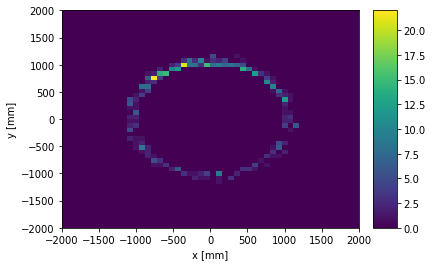

In [30]:
hist_xy = Hist(
    hist.axis.Regular(50, -2000, 2000, name="x", label="x [mm]", flow=False),
    hist.axis.Regular(50, -2000, 2000, name="y", label="y [mm]", flow=False),
)
hist_xy.fill(df.x, df.y)
hist_xy.plot2d()

<AxesSubplot:xlabel='x', ylabel='y'>

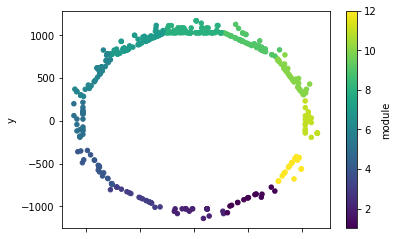

In [17]:
df.plot.scatter(x='x', y='y', c='module', colormap='viridis')

<AxesSubplot:xlabel='x', ylabel='y'>

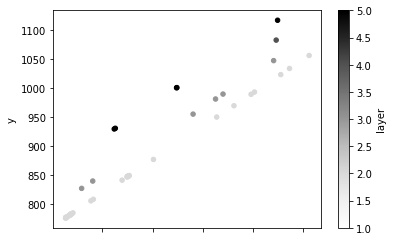

In [32]:
mask = df.module == 7
df[mask].plot.scatter(x='x', y='y', c='layer', colormap='viridis')


In [26]:
#How many hits we have in each module? 

print("hits per module")
for module, group in df.groupby('module'):
    print(f"module={int(module)}     Nhits ={len(group)}")

hits per module
module=1     Nhits =16
module=2     Nhits =24
module=3     Nhits =20
module=4     Nhits =30
module=5     Nhits =24
module=6     Nhits =54
module=7     Nhits =114
module=8     Nhits =94
module=9     Nhits =59
module=10     Nhits =54
module=11     Nhits =23
module=12     Nhits =24
